# Regression and DNN Model 


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pydot
import time
import datetime

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [25]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import kerastuner as kt
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import KFold

print(tf.__version__)

2.4.1


# Get Dataset

In [26]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


# Check Null values

In [27]:
#The dataset contains a few unknown values.
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [28]:
#Drop those rows to keep this initial tutorial simple.
dataset = dataset.dropna()

## Data Adjusting 

In [29]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


# Splitting Data to training and testing data

In [30]:
train_dataset = dataset.sample(frac=0.8, random_state=0)



test_dataset = dataset.drop(train_dataset.index)



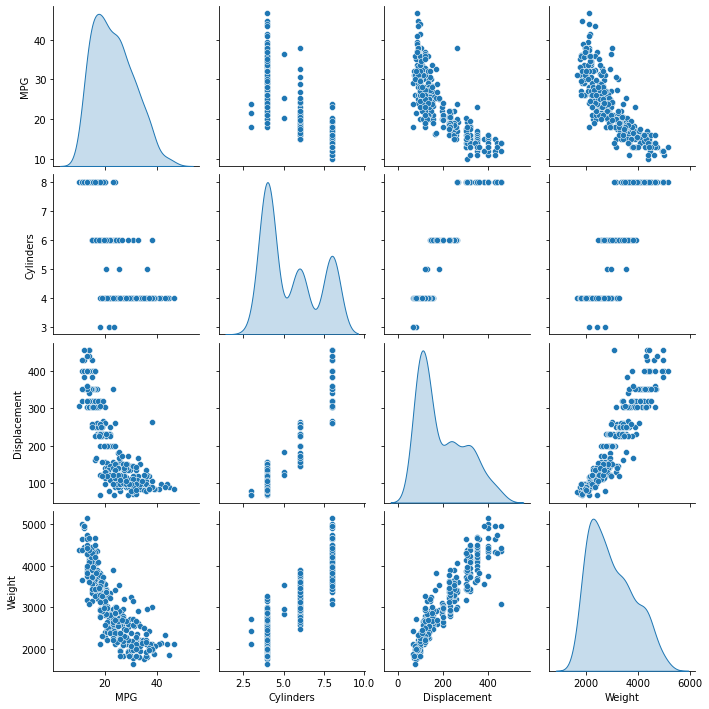

In [31]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [32]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [33]:
#Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.
train_features = train_dataset.copy()
test_features = test_dataset.copy()


train_labels_0 = train_features[['MPG']].copy()
train_labels_1 = train_features[['Weight']].copy()

train_features = train_features.drop(['MPG','Weight'], axis=1)

test_labels_0 = test_features[['MPG']].copy()
test_labels_1 = test_features[['Weight']].copy()

test_features = test_features.drop(['MPG','Weight'], axis=1)

In [34]:
#In the table of statistics it's easy to see how different the ranges of each feature are.
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


# Data Normalization


In [35]:

normalizer = preprocessing.Normalization()

normalizer.adapt(np.array(train_features))

print(normalizer.mean.numpy())

print(type(normalizer))


[  5.478 195.318 104.869  15.559  75.898   0.178   0.197   0.624]
<class 'tensorflow.python.keras.layers.preprocessing.normalization.Normalization'>


In [36]:
first = np.array(train_features[:1])
tx = np.array(train_features)


with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 4.  90.  75.  14.5 74.   0.   0.   1. ]]

Normalized: [[-0.87 -1.01 -0.79 -0.38 -0.52 -0.47 -0.5   0.78]]


# Keras Functional API Model


In [37]:
def build_and_compile_model_0(norm):
    inputs = keras.Input(shape=(8,))

    dense = layers.Dense(64, activation="relu")
    x = dense(inputs)

    x = layers.Dense(64, activation="relu")(x)

    output_mph = layers.Dense(1)(x)
    output_wt = layers.Dense(1)(x)


    model = keras.Model(inputs=inputs, outputs=[output_mph,output_wt])
    model.compile(loss=['mean_squared_error','mean_squared_error'], optimizer=tf.keras.optimizers.Adam(0.001),metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.Accuracy(name='accuracy', dtype=None)]
    )
    return model
    
Name = 'ANN multioutputs regression '+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
Tensor_Board = keras.callbacks.TensorBoard(
    log_dir="../Model_0/Name/{}".format(Name),
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

In [38]:
dnn_model = build_and_compile_model_0(normalizer)

In [39]:
#dnn_model.summary()

In [40]:
#keras.utils.plot_model(dnn_model, "multi_input_and_output_model.png", show_shapes=True)


In [41]:
%%time
history = dnn_model.fit(train_features, y=(train_labels_0,train_labels_1), batch_size=64, epochs=60, callbacks= Tensor_Board,validation_split=0.1)


Epoch 1/60
5/5 [==============================] - 3s 527ms/step - loss: 9346203.8333 - dense_6_loss: 536.0980 - dense_7_loss: 9345667.1667 - dense_6_mean_absolute_error: 22.6260 - dense_6_accuracy: 0.0000e+00 - dense_7_mean_absolute_error: 2948.6353 - dense_7_accuracy: 0.0000e+00 - val_loss: 10078399.0000 - val_dense_6_loss: 471.2823 - val_dense_7_loss: 10077928.0000 - val_dense_6_mean_absolute_error: 20.7977 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mean_absolute_error: 3048.1885 - val_dense_7_accuracy: 0.0000e+00
Epoch 2/60
5/5 [==============================] - 0s 27ms/step - loss: 9414574.6667 - dense_6_loss: 430.3403 - dense_7_loss: 9414144.8333 - dense_6_mean_absolute_error: 19.8688 - dense_6_accuracy: 0.0000e+00 - dense_7_mean_absolute_error: 2951.4094 - dense_7_accuracy: 0.0000e+00 - val_loss: 9810839.0000 - val_dense_6_loss: 380.8578 - val_dense_7_loss: 9810458.0000 - val_dense_6_mean_absolute_error: 17.8967 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mean_absolute

# Model Evaluation

None


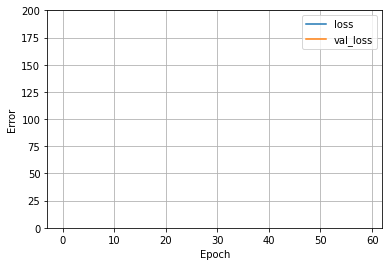

In [42]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 200])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
print(plot_loss(history))

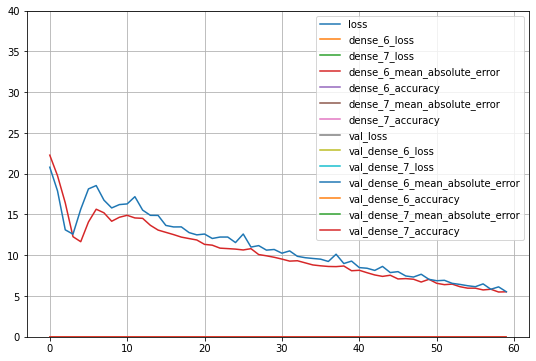

In [43]:
pd.DataFrame(history.history).plot(figsize=(9, 6))
plt.grid(True)
plt.gca().set_ylim(0, 40) 
plt.show()

In [44]:
dnn_model.evaluate(test_features, y=(test_labels_0,test_labels_1), verbose=0)

[80302.765625,
 62.6455078125,
 80240.1171875,
 6.1294941902160645,
 0.0,
 209.06468200683594,
 0.0]

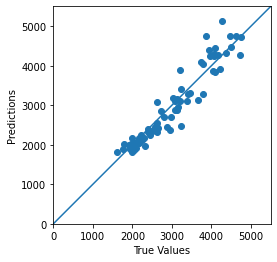

In [45]:
test_predictions = dnn_model.predict(test_features)

a = plt.axes(aspect='equal')
plt.scatter(test_labels_1, test_predictions[1])
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 5500]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


In [46]:
#Save the model 
#dnn_model.save('my_model.h5')
#To restore the model use: dnn_model = tf.keras.models.load_model('my_model.h5')